<a href="https://colab.research.google.com/github/asante69/acee/blob/main/Sentiment_Analysis_and_Model_Testing_Manufacturing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import your libraries for sentiment analysis

In [1]:
!pip install transformers
!pip install sentencepiece
!pip install nltk
!python -m nltk.downloader punkt
!pip install pandas
!pip install pyLDAvis
!pip install sklearn
!pip install gensim

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 40.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import numpy as np
import datetime as dt
import pandas as pd
import sklearn as sk
import sklearn.metrics as skm
import sklearn.cluster as skc
import sklearn.preprocessing as skp
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns
import string
import re
import nltk
from textblob import TextBlob
from wordcloud import WordCloud
import networkx as nx

import gensim
from gensim.utils import simple_preprocess
import scipy as sp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##Load your scrapped Data

In [3]:
try:
    df1 = pd.read_csv('CAT.csv')
    df2 = pd.read_csv('ETN.csv')
    df3 = pd.read_csv('GE.csv')
    df4 = pd.read_csv('RTX.csv')


    # Concatenate the dataframes
    df = pd.concat([df1, df2, df3, df4], ignore_index=True)

    # Print some info about the concatenated dataframe (optional)
    print(df.info())

except FileNotFoundError:
    print("One or more data files not found. Please check the filenames and paths.")
except pd.errors.EmptyDataError:
    print("One or more data files are empty.")
except Exception as e:
    print(f"An error occurred: {e}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4241 entries, 0 to 4240
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Date     4241 non-null   object
 1   Comment  3975 non-null   object
dtypes: object(2)
memory usage: 66.4+ KB
None


In [4]:
df.head()

,Date,Comment
0,23/2/25,over over over sold. RSI 27
1,23/2/25,#NAME?
2,23/2/25,Am looking for the 100 EMA test on the weekly TF
3,23/2/25,"16% in a month is absurd. When it moves, it sh..."
4,23/2/25,looking bullish! Strong uptrend forming. Bulls...


In [5]:
df.duplicated().sum()

229

In [6]:
df.drop_duplicates(keep='first', inplace=True)

In [7]:
df['Comment'].nunique()

3617

##Load Stopwords

In [8]:
# Load stop words
stop_words = stopwords.words('english')

# Show stop words
stop_words[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

##Perform data cleaning by removing hastags, urls, mentions, symbols, www, pictures, emoji, etc

In [9]:

# Removing hashtags and mentions
def get_hashtags(text):
    hashtags = re.findall(r'\#\w+',text.lower())
    return hashtags
def get_mentions(text):
    mentions = re.findall(r'\@\w+',text.lower())
    return mentions

# Cleaning up the text of the tweets
def remove_content(text):
    text = re.sub(r"http\S+", "", text) #remove urls
    text=re.sub(r'\S+\.com\S+','',text) #remove urls
    text=re.sub(r'\@\w+','',text) #remove mentions
    text =re.sub(r'\#\w+','',text) #remove hashtags
    return text

def process_tweet(tweet):
    """
    tweets cleaning by
    1) lowering the case of the tweet,
    2) removing unwanted symbols and replacing them with a whitespace,
    3) split sentences into words according to whitespaces and then
    4) join back with a single whitespace as separator between various words
    """
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

def process_text(text, stem=False): #clean text
    text=remove_content(text)
    lemmatizer=WordNetLemmatizer()
    text = re.sub('[^A-Za-z]', ' ', text.lower()) #remove non-alphabets
    text = re.sub(r'@[A-Za-z0-9]+', '', str(text)) # remove @mentions
    text = re.sub(r'#', '',  str(text)) # remove the '#' symbol
    text = re.sub(r'RT[\s]+', '',  str(text)) # remove RT
    text = re.sub(r'https?\/\/S+', '',  str(text)) # remove the hyperlink
    text = re.sub(r'http\S+', '',  str(text)) # remove the hyperlink
    text = re.sub(r'www\S+', '',  str(text)) # remove the www
    text = re.sub(r'pic+', '',  str(text)) # remove the pic
    text = re.sub(r'com', '',  str(text)) # remove the pic
    text = re.sub(r"\bamp\b", ' ', text.lower()) #remove "amp" which is coming from the translation of &
    text = re.sub(r"\bco\b", ' ', text.lower()) #remove "co" which was one of the top words found below
    tokenized_text = word_tokenize(text) #tokenize
    #tokenized_text = [lemmatizer.lemmatize(word) for word in tokenized_text]
    clean_text = [
         word for word in tokenized_text
         if (word not in stop_words and len(word)>1)
    ]
    if stem:
        clean_text=[stemmer.stem(word) for word in clean_text]
    clean_text = [lemmatizer.lemmatize(word) for word in clean_text]
    return ' '.join(clean_text)

#functions used to remove search terms from all the tweets
#function to remove duplicates from a string - in this case the string is the keywords used to scrape the tweets
def removeDupWithoutOrder(string):
    words = string.lower().split()
    return " ".join(sorted(set(words), key=words.index)).replace('OR', '').replace('  ', ' ')

#function to search for string i.e. remove specific words (search_terms in this case)
def remove_search(text, search_terms):
    query = text.lower()
    querywords = query.split()
    resultwords  = [word for word in querywords if word.lower() not in search_terms]
    return ' '.join(resultwords)

# define function to plot frequency of bi-grams, tri-grams, single words, phrases etc
from sklearn.feature_extraction.text import CountVectorizer
def plot_topn(sentences, ngram_range=(1,3), top=20,firstword=''):
    c=CountVectorizer(ngram_range=ngram_range)
    X=c.fit_transform(sentences)
    words=pd.DataFrame(X.sum(axis=0),columns=c.get_feature_names()).T.sort_values(0,ascending=False).reset_index()
    res=words[words['index'].apply(lambda x: firstword in x)].head(top)
    pl=px.bar(res, x='index',y=0)
    pl.update_layout(yaxis_title='count',xaxis_title='Phrases')

In [10]:
import re
re.compile('<title>(.*)</title>')

re.compile(r'<title>(.*)</title>', re.UNICODE)

In [11]:
# removing useless content (hashtags, mentions)
df['Comment'].apply(str)

,Comment
0,over over over sold. RSI 27
1,#NAME?
2,Am looking for the 100 EMA test on the weekly TF
3,"16% in a month is absurd. When it moves, it sh..."
4,looking bullish! Strong uptrend forming. Bulls...
...,...
4236,nan
4237,massive share dumping
4238,While this seems like a huge loss for Palantir...
4239,"This might be the strongest stock of all time,..."


In [12]:
df['cleaned_comments'] = df['Comment'].astype(str).apply(lambda x: process_tweet(x))

In [13]:
df

,Date,Comment,cleaned_comments
0,23/2/25,over over over sold. RSI 27,over over over sold rsi 27
1,23/2/25,#NAME?,name
2,23/2/25,Am looking for the 100 EMA test on the weekly TF,am looking for the 100 ema test on the weekly tf
3,23/2/25,"16% in a month is absurd. When it moves, it sh...",16 in a month is absurd when it moves it shoul...
4,23/2/25,looking bullish! Strong uptrend forming. Bulls...,looking bullish strong uptrend forming bulls a...
...,...,...,...
4236,20/8/24,NaN,nan
4237,20/8/24,massive share dumping,massive share dumping
4238,20/8/24,While this seems like a huge loss for Palantir...,while this seems like a huge loss for palantir...
4239,20/8/24,"This might be the strongest stock of all time,...",this might be the strongest stock of all time ...


###Check the number of comments or reviews in the dataset

In [14]:
df['cleaned_comments'].nunique()

3538

In [15]:
#Save cleaned_comments data
df.to_csv('cleaned_comments.csv', index=False)

In [16]:
df['Comment'] = df['Comment'].str.replace('http\S+', '')


###Generate Word Frequency to analyze the most occuring word within the dataset

In [17]:
from PIL import Image
import urllib
import requests
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

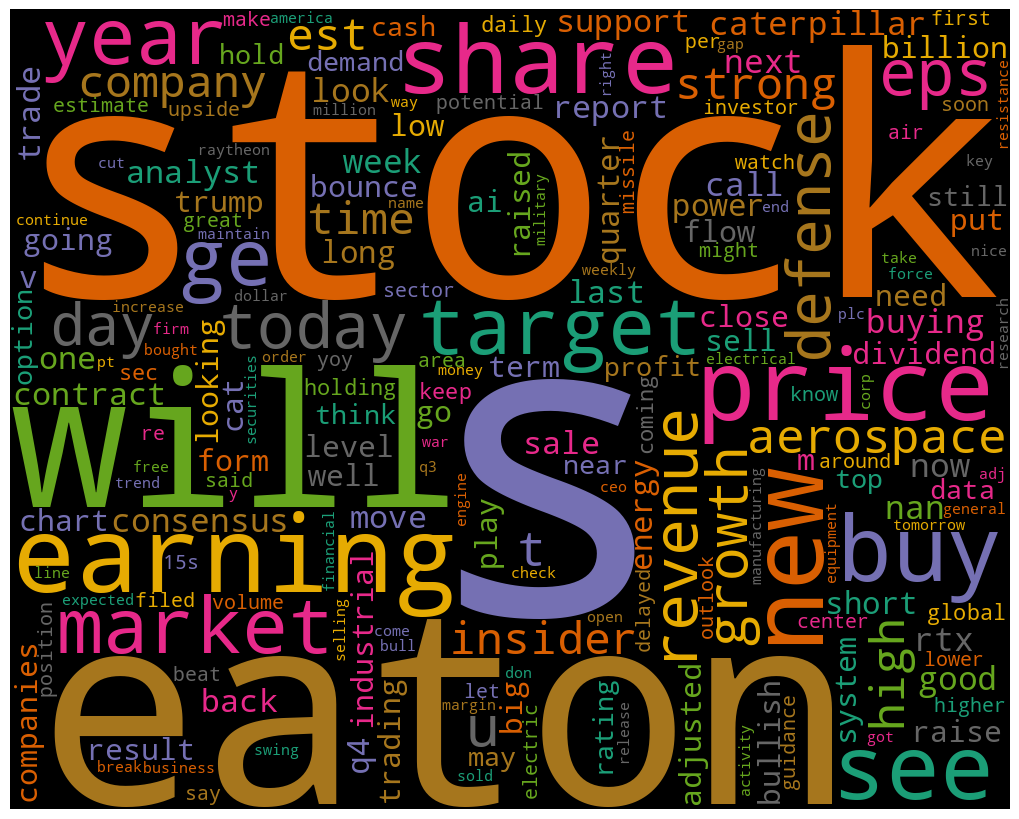

In [18]:
comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df.cleaned_comments:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 1000, height = 800,
                background_color='black', colormap='Dark2',
                collocations=False,
                stopwords = stopwords,
                min_font_size = 12).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

###Plot Polarity and Subjectivity Scores

In [19]:
def getSubjectivity(text):
    return TextBlob( str(text)).sentiment.subjectivity

def getPolarity(text):
    return TextBlob( str(text)).sentiment.polarity

In [20]:
df.dropna(subset=['cleaned_comments'], inplace = True)
df.reset_index(drop=True, inplace=True)

In [21]:
df['Subjectivity'] = df['cleaned_comments'].apply(getSubjectivity)
df['Polarity'] = df['cleaned_comments'].apply(getPolarity)
df.head()

,Date,Comment,cleaned_comments,Subjectivity,Polarity
0,23/2/25,over over over sold. RSI 27,over over over sold rsi 27,0.000000,0.000000
1,23/2/25,#NAME?,name,0.000000,0.000000
2,23/2/25,Am looking for the 100 EMA test on the weekly TF,am looking for the 100 ema test on the weekly tf,0.000000,0.000000
3,23/2/25,"16% in a month is absurd. When it moves, it sh...",16 in a month is absurd when it moves it shoul...,0.800000,-0.150000
4,23/2/25,looking bullish! Strong uptrend forming. Bulls...,looking bullish strong uptrend forming bulls a...,0.577778,0.294444


In [22]:

def get_Polarity_Analysis(score):
    if score < 0:
      return 'Negative'
    elif score == 0:
      return 'Neutral'
    else:
      return 'Positive'
def get_Subjectivity_Analysis(score):
    if score >  0:
      return 'Opinion'
    else:
      return 'Fact'

df['Analysis_Polarity'] = df['Polarity'].apply(get_Polarity_Analysis)

df['Analysis_Subjectivity'] = df['Subjectivity'].apply(get_Subjectivity_Analysis)

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(font_scale=2)

###Plot Polarity and Subjectiviy Score in Scatter Plot

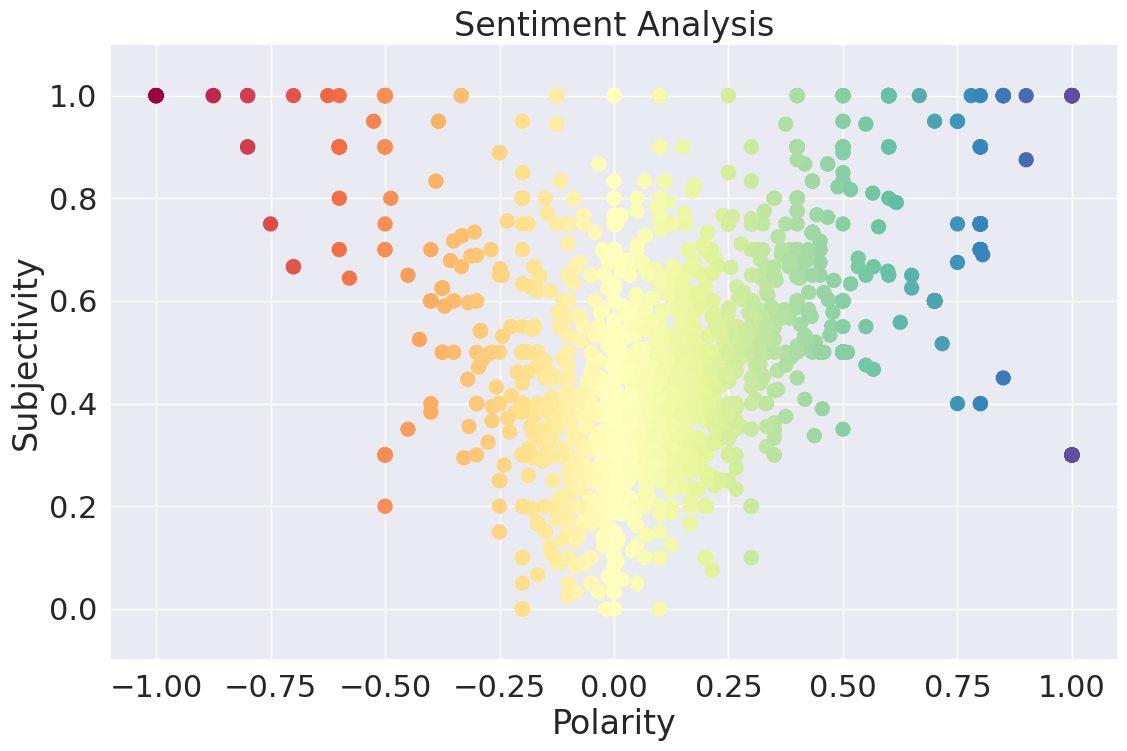

(None,)

In [24]:
plt.figure(figsize=(13,8))

plt.scatter(df['Polarity'], df['Subjectivity'], c=df['Polarity'], s=100, cmap='Spectral')

plt.xlim(-1.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show(),

In [25]:
df['Sentiment'] = df.apply(lambda x: ' '.join([str(x['Analysis_Polarity']),str(x['Analysis_Subjectivity'])]),axis=1)
df.head()


,Date,Comment,cleaned_comments,Subjectivity,Polarity,Analysis_Polarity,Analysis_Subjectivity,Sentiment
0,23/2/25,over over over sold. RSI 27,over over over sold rsi 27,0.000000,0.000000,Neutral,Fact,Neutral Fact
1,23/2/25,#NAME?,name,0.000000,0.000000,Neutral,Fact,Neutral Fact
2,23/2/25,Am looking for the 100 EMA test on the weekly TF,am looking for the 100 ema test on the weekly tf,0.000000,0.000000,Neutral,Fact,Neutral Fact
3,23/2/25,"16% in a month is absurd. When it moves, it sh...",16 in a month is absurd when it moves it shoul...,0.800000,-0.150000,Negative,Opinion,Negative Opinion
4,23/2/25,looking bullish! Strong uptrend forming. Bulls...,looking bullish strong uptrend forming bulls a...,0.577778,0.294444,Positive,Opinion,Positive Opinion


###Plot Polarity Score for the entire dataset using bar chart

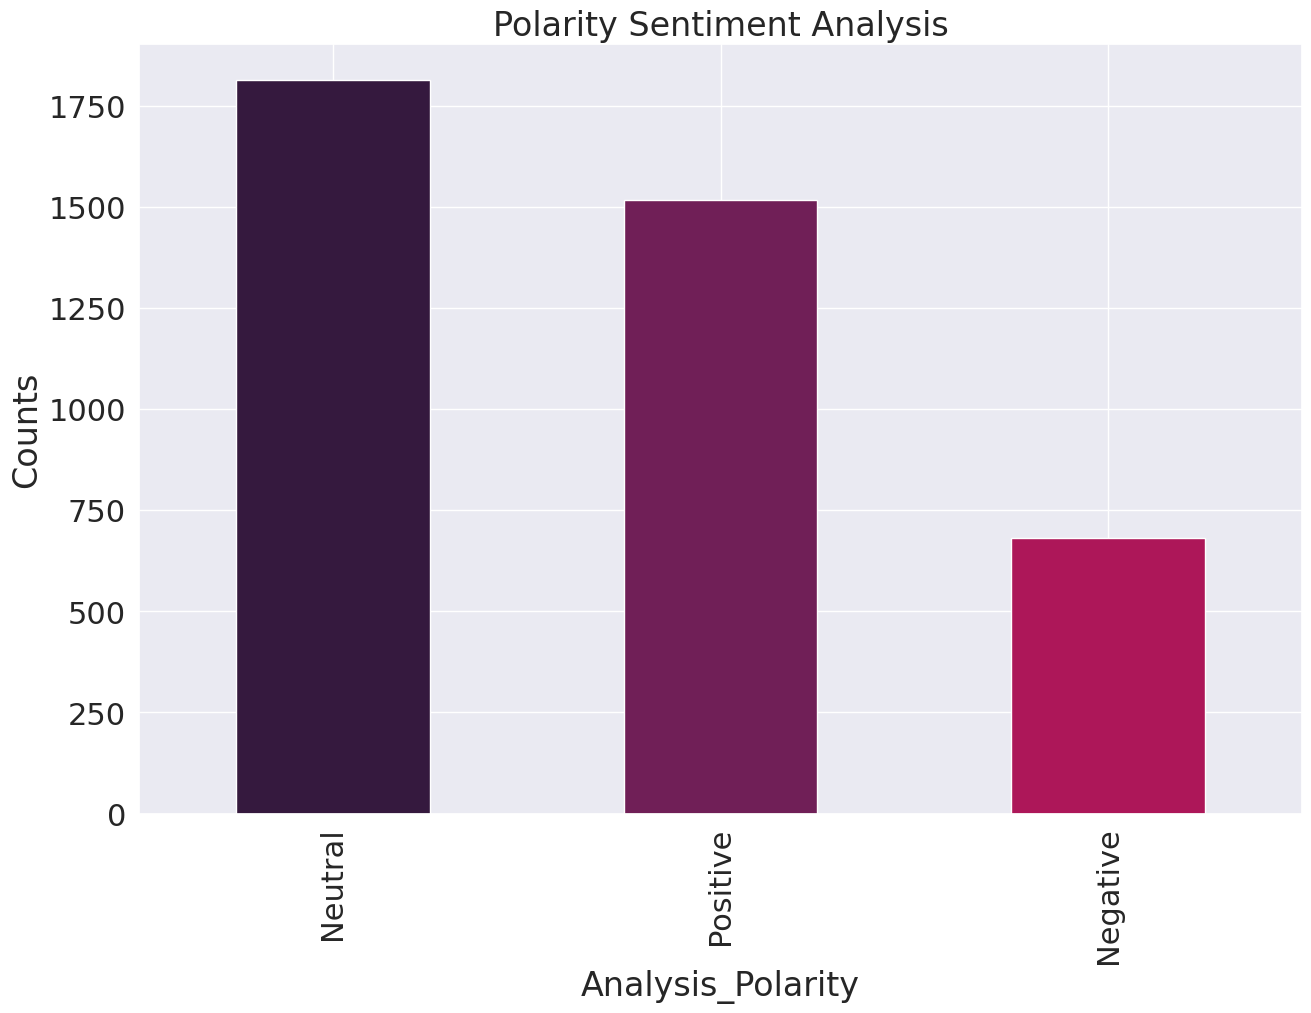

In [26]:

plt.figure(figsize=(15,10))

plt.title('Polarity Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis_Polarity'].value_counts().plot(kind = 'bar',  color=sns.palettes.mpl_palette('rocket'))
plt.show()

###Plot Subjectivity and Objective

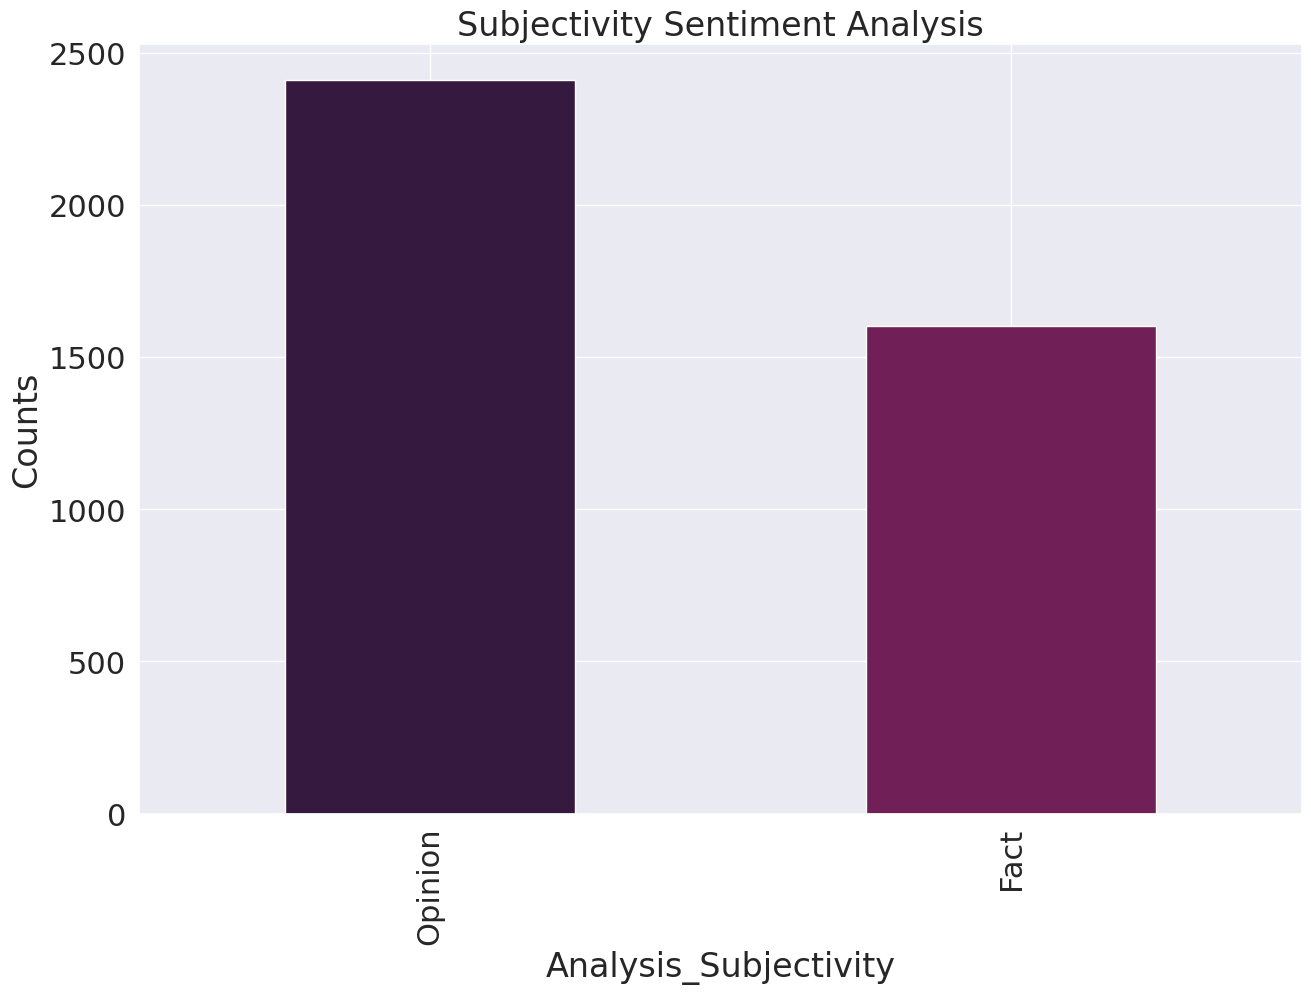

In [27]:
plt.figure(figsize=(15,10))
plt.title('Subjectivity Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df['Analysis_Subjectivity'].value_counts().plot(kind = 'bar',  color=sns.palettes.mpl_palette('rocket'))
plt.show()


In [28]:
import pyLDAvis
import pyLDAvis.gensim
import pickle
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [29]:
!pip install gensim

In [30]:

pyLDAvis.enable_notebook()


In [31]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5,
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(df['cleaned_comments'].values.astype('U'))
print(dtm_tf.shape)

(4012, 810)


In [32]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_comments'].values.astype('U'))
print(dtm_tfidf.shape)

(4012, 810)


In [33]:
# for TF DTM
lda_tf = LatentDirichletAllocation(n_components =10, random_state=50)
lda_tf.fit(dtm_tf)
# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components =10, random_state=50)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(random_state=50)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [35]:
import pyLDAvis.lda_model
...
pyLDAvis.lda_model.prepare

<function pyLDAvis.lda_model.prepare(lda_model, dtm, vectorizer, **kwargs)>

In [36]:
nltk.download('stopwords')
from nltk.corpus import stopwords  # Import the stopwords module

english_stopwords = stopwords.words('english')  # Call words on the module
english_stopwords.extend(['from', 'subject', 're', 'edu', 'use'])

def sentences_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuation.
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in english_stopwords] for doc in texts]

comments = df.cleaned_comments.to_list()
comment_words = list(sentences_to_words(comments))

# Remove stop words.
comment_words = remove_stopwords(comment_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [37]:
import gensim.corpora as corpora

# Create Dictionary.
id2word = corpora.Dictionary(comment_words)

# Create Corpus.
texts = comment_words

# Term Document Frequency.
corpus = [id2word.doc2bow(text) for text in texts]

In [38]:
from pprint import pprint

# Number of topics.
num_topics = 10

# Build LDA model.
lda_model = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics
)

# Print the Keyword in the 10 topics.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.010*"defense" + 0.007*"revenue" + 0.006*"see" + 0.006*"year" + '
  '0.005*"new" + 0.005*"shares" + 0.005*"billion" + 0.004*"insider" + '
  '0.004*"could" + 0.004*"long"'),
 (1,
  '0.021*"foreign" + 0.020*"sound" + 0.020*"el" + 0.018*"segundo" + '
  '0.017*"also" + 0.016*"stock" + 0.015*"time" + 0.015*"go" + '
  '0.014*"literally" + 0.014*"might"'),
 (2,
  '0.008*"eaton" + 0.007*"eps" + 0.006*"vs" + 0.006*"est" + 0.005*"earnings" + '
  '0.005*"revenue" + 0.004*"support" + 0.004*"see" + 0.004*"shares" + '
  '0.004*"contract"'),
 (3,
  '0.029*"got" + 0.023*"gain" + 0.023*"hamas" + 0.023*"advantage" + '
  '0.023*"would" + 0.023*"netanyahu" + 0.017*"holding" + 0.016*"even" + '
  '0.014*"also" + 0.013*"el"'),
 (4,
  '0.024*"system" + 0.022*"like" + 0.022*"around" + 0.022*"huge" + '
  '0.022*"share" + 0.021*"anyone" + 0.021*"would" + 0.021*"massive" + '
  '0.021*"uses" + 0.021*"loss"'),
 (5,
  '0.015*"netanyahu" + 0.013*"would" + 0.011*"advantage" + 0.010*"hamas" + '
  '0.010*"got" 

In [39]:
import pyLDAvis
import pyLDAvis.gensim
import pickle
import os

# Visualize the topics.
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join(f'cleaned_comments_lda_{num_topics}.data')

if os.path.exists(LDAvis_data_filepath):
    # Load the pre-prepared pyLDAvis data from disk.
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
else:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

pyLDAvis.save_html(LDAvis_prepared, f'{LDAvis_data_filepath}.html')

In [40]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.023497  0.030619       1        1  16.474615
0      0.153018  0.058667       2        1  15.499891
2      0.146556  0.053036       3        1  15.015763
8      0.149680  0.108571       4        1  13.898603
5      0.098441  0.020710       5        1  10.776412
7     -0.080201  0.042882       6        1   9.274477
4     -0.135711  0.011409       7        1   6.648130
9      0.183413 -0.255252       8        1   5.383478
1     -0.242186 -0.019376       9        1   4.238401
3     -0.249512 -0.051267      10        1   2.790231, topic_info=            Term        Freq       Total Category  logprob  loglift
1263  overvalued  306.000000  306.000000  Default  30.0000  30.0000
2132  overbought  311.000000  311.000000  Default  29.0000  29.0000
957        alert  322.000000  322.000000  Default  28.0000  28.0000
374        trend  321.000000  321.000000  Default  27.0000  27.0000
402       signal  321.000000  321.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
387      holding   21.689059  202.884163  Topic10  -4.0957   1.3432
7061     segundo   15.893658  153.840232  Topic10  -4.4066   1.3091
83           see   16.243282  161.564827  Topic10  -4.3848   1.2818
261         also   17.794188  188.680593  Topic10  -4.2936   1.2179
2581       sound   14.081357  153.265471  Topic10  -4.5277   1.1917

[602 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
424       1  0.140906  active
424       2  0.140906  active
424       4  0.140906  active
424       7  0.422719  active
1384      2  0.068286     adj
...     ...       ...     ...
62        4  0.068289   years
62        5  0.318684   years
62        6  0.022763   years
62        8  0.022763   years
62        9  0.022763   years

[1920 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 1, 3, 9, 6, 8, 5, 10, 2, 4])

In [47]:
topic_values = lda_tf.transform(dtm_tf)
topic_values.shape

(4012, 10)

In [42]:
df.head()

,Date,Comment,cleaned_comments,Subjectivity,Polarity,Analysis_Polarity,Analysis_Subjectivity,Sentiment
0,23/2/25,over over over sold. RSI 27,over over over sold rsi 27,0.000000,0.000000,Neutral,Fact,Neutral Fact
1,23/2/25,#NAME?,name,0.000000,0.000000,Neutral,Fact,Neutral Fact
2,23/2/25,Am looking for the 100 EMA test on the weekly TF,am looking for the 100 ema test on the weekly tf,0.000000,0.000000,Neutral,Fact,Neutral Fact
3,23/2/25,"16% in a month is absurd. When it moves, it sh...",16 in a month is absurd when it moves it shoul...,0.800000,-0.150000,Negative,Opinion,Negative Opinion
4,23/2/25,looking bullish! Strong uptrend forming. Bulls...,looking bullish strong uptrend forming bulls a...,0.577778,0.294444,Positive,Opinion,Positive Opinion


In [48]:
df_1=df.replace({0:' Insider Trading',1:'Stock Performance',2:'AI & Data Centers',3:'Price Targets',4:'Energy & Power Sector',5:'Defense Collaborations',6:'Stock Disclosures',7:'Chinese Market',8:'Company Acquisitions',9:'Financial Reports'})

In [44]:
df_1['topic'] = topic_values.argmax(axis=1)

In [49]:
df['Topic'] = topic_values.argmax(axis=1)

In [50]:
df_1.head()

,Date,Comment,cleaned_comments,Subjectivity,Polarity,Analysis_Polarity,Analysis_Subjectivity,Sentiment,Topic
0,23/2/25,over over over sold. RSI 27,over over over sold rsi 27,Insider Trading,Insider Trading,Neutral,Fact,Neutral Fact,Financial Reports
1,23/2/25,#NAME?,name,Insider Trading,Insider Trading,Neutral,Fact,Neutral Fact,Insider Trading
2,23/2/25,Am looking for the 100 EMA test on the weekly TF,am looking for the 100 ema test on the weekly tf,Insider Trading,Insider Trading,Neutral,Fact,Neutral Fact,Insider Trading
3,23/2/25,"16% in a month is absurd. When it moves, it sh...",16 in a month is absurd when it moves it shoul...,0.8,-0.15,Negative,Opinion,Negative Opinion,Chinese Market
4,23/2/25,looking bullish! Strong uptrend forming. Bulls...,looking bullish strong uptrend forming bulls a...,0.577778,0.294444,Positive,Opinion,Positive Opinion,Insider Trading


In [51]:
df_1.columns

Index(['Date', 'Comment', 'cleaned_comments', 'Subjectivity', 'Polarity',
       'Analysis_Polarity', 'Analysis_Subjectivity', 'Sentiment', 'Topic'],
      dtype='object')

<Figure size 4000x2500 with 0 Axes>

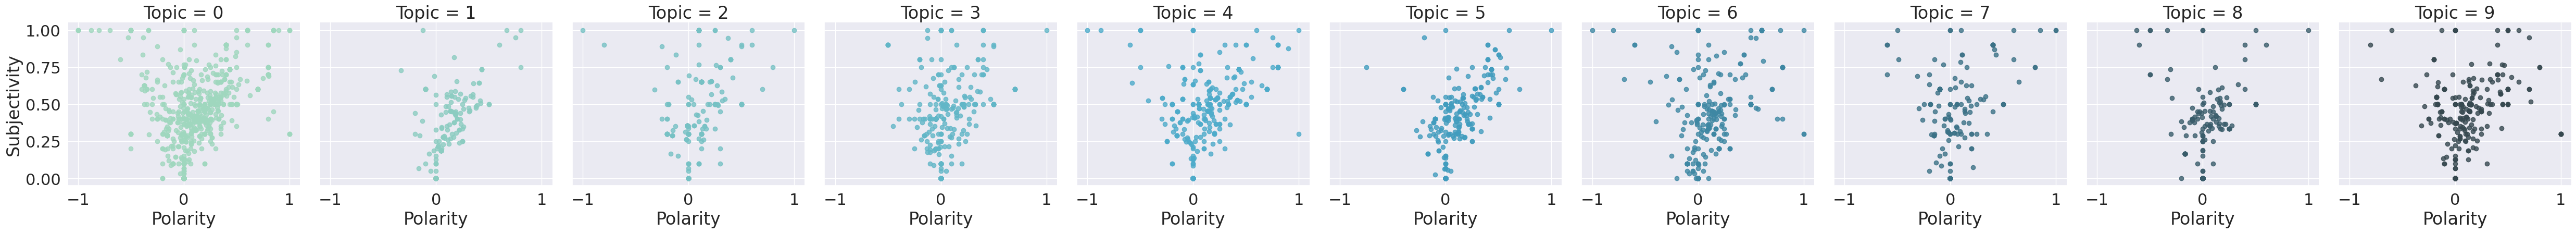

In [52]:
plt.figure(figsize=(40,25))

g=sns.lmplot(x="Polarity", y="Subjectivity", hue='Topic', data=df, fit_reg=False, legend=False,palette="GnBu_d", col='Topic', legend_out=True)


plt.show()

In [53]:
df_2 = df_1.groupby(['Topic'])['Analysis_Polarity'].value_counts().unstack('Topic').transpose()

df_2

Analysis_Polarity,Negative,Neutral,Positive
Topic,,,
Insider Trading,158,543,394
AI & Data Centers,67,77,116
Chinese Market,59,275,65
Company Acquisitions,43,181,61
Defense Collaborations,41,126,138
Energy & Power Sector,72,122,199
Financial Reports,70,111,162
Price Targets,91,169,112
Stock Disclosures,51,140,155


In [54]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries,  Insider Trading to Stock Performance
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Negative  10 non-null     int64
 1   Neutral   10 non-null     int64
 2   Positive  10 non-null     int64
dtypes: int64(3)
memory usage: 320.0+ bytes


In [55]:
df_2['Total'] = df_2.sum(axis=1)

In [56]:
df_2.columns

Index(['Negative', 'Neutral', 'Positive', 'Total'], dtype='object', name='Analysis_Polarity')

In [57]:
for i in df_2:
    df_2[i] = round(df_2[i]*100/df_2.Total)

df_2

Analysis_Polarity,Negative,Neutral,Positive,Total
Topic,,,,
Insider Trading,14.0,50.0,36.0,100.0
AI & Data Centers,26.0,30.0,45.0,100.0
Chinese Market,15.0,69.0,16.0,100.0
Company Acquisitions,15.0,64.0,21.0,100.0
Defense Collaborations,13.0,41.0,45.0,100.0
Energy & Power Sector,18.0,31.0,51.0,100.0
Financial Reports,20.0,32.0,47.0,100.0
Price Targets,24.0,45.0,30.0,100.0
Stock Disclosures,15.0,40.0,45.0,100.0


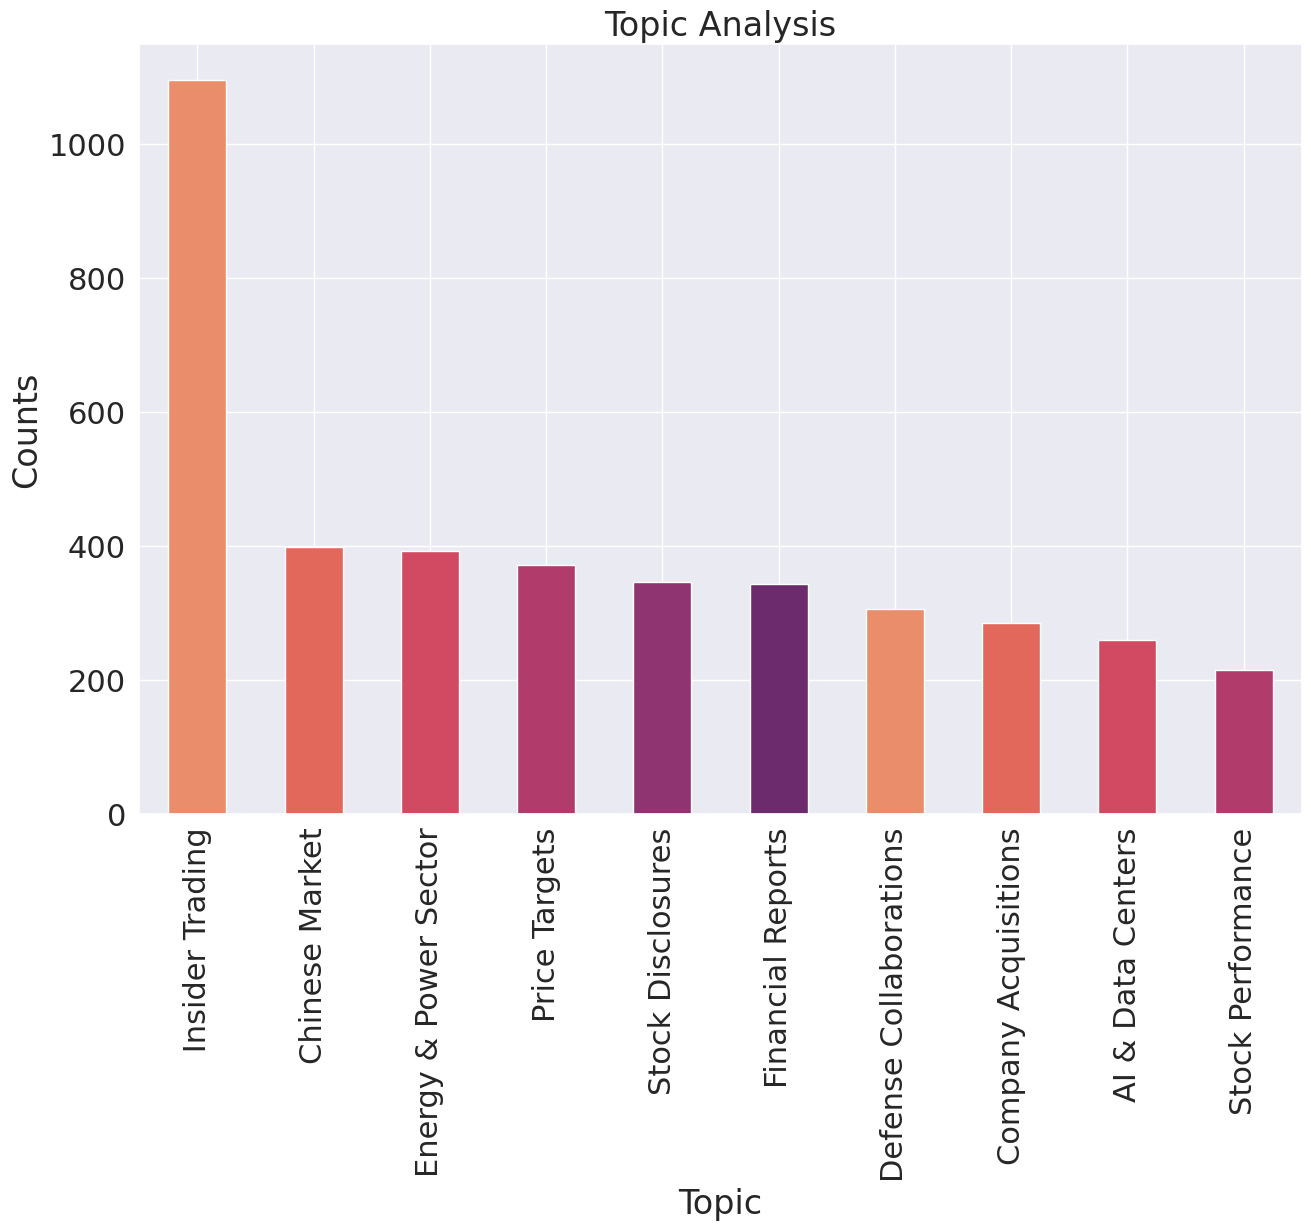

In [58]:
# Plot and visualizing the counts for each topic
plt.figure(figsize=(15,10))

plt.title('Topic Analysis')
plt.xlabel('Topic')
plt.ylabel('Counts')
df_1['Topic'].value_counts().plot(kind = 'bar',  color=sns.palettes.mpl_palette('flare'))
plt.show()


In [59]:
df_2=df_2.fillna(0)

In [60]:
df_2['Total'] = df_2.sum(axis=1)
df_2 = df_2.drop(['Total'], axis=1)

In [61]:
print(df_2.shape)

(10, 3)


In [62]:
print(df_2.head())

Analysis_Polarity       Negative  Neutral  Positive
Topic                                              
 Insider Trading            14.0     50.0      36.0
AI & Data Centers           26.0     30.0      45.0
Chinese Market              15.0     69.0      16.0
Company Acquisitions        15.0     64.0      21.0
Defense Collaborations      13.0     41.0      45.0


In [63]:
print(df_2.tail())

Analysis_Polarity      Negative  Neutral  Positive
Topic                                             
Energy & Power Sector      18.0     31.0      51.0
Financial Reports          20.0     32.0      47.0
Price Targets              24.0     45.0      30.0
Stock Disclosures          15.0     40.0      45.0
Stock Performance          14.0     32.0      54.0


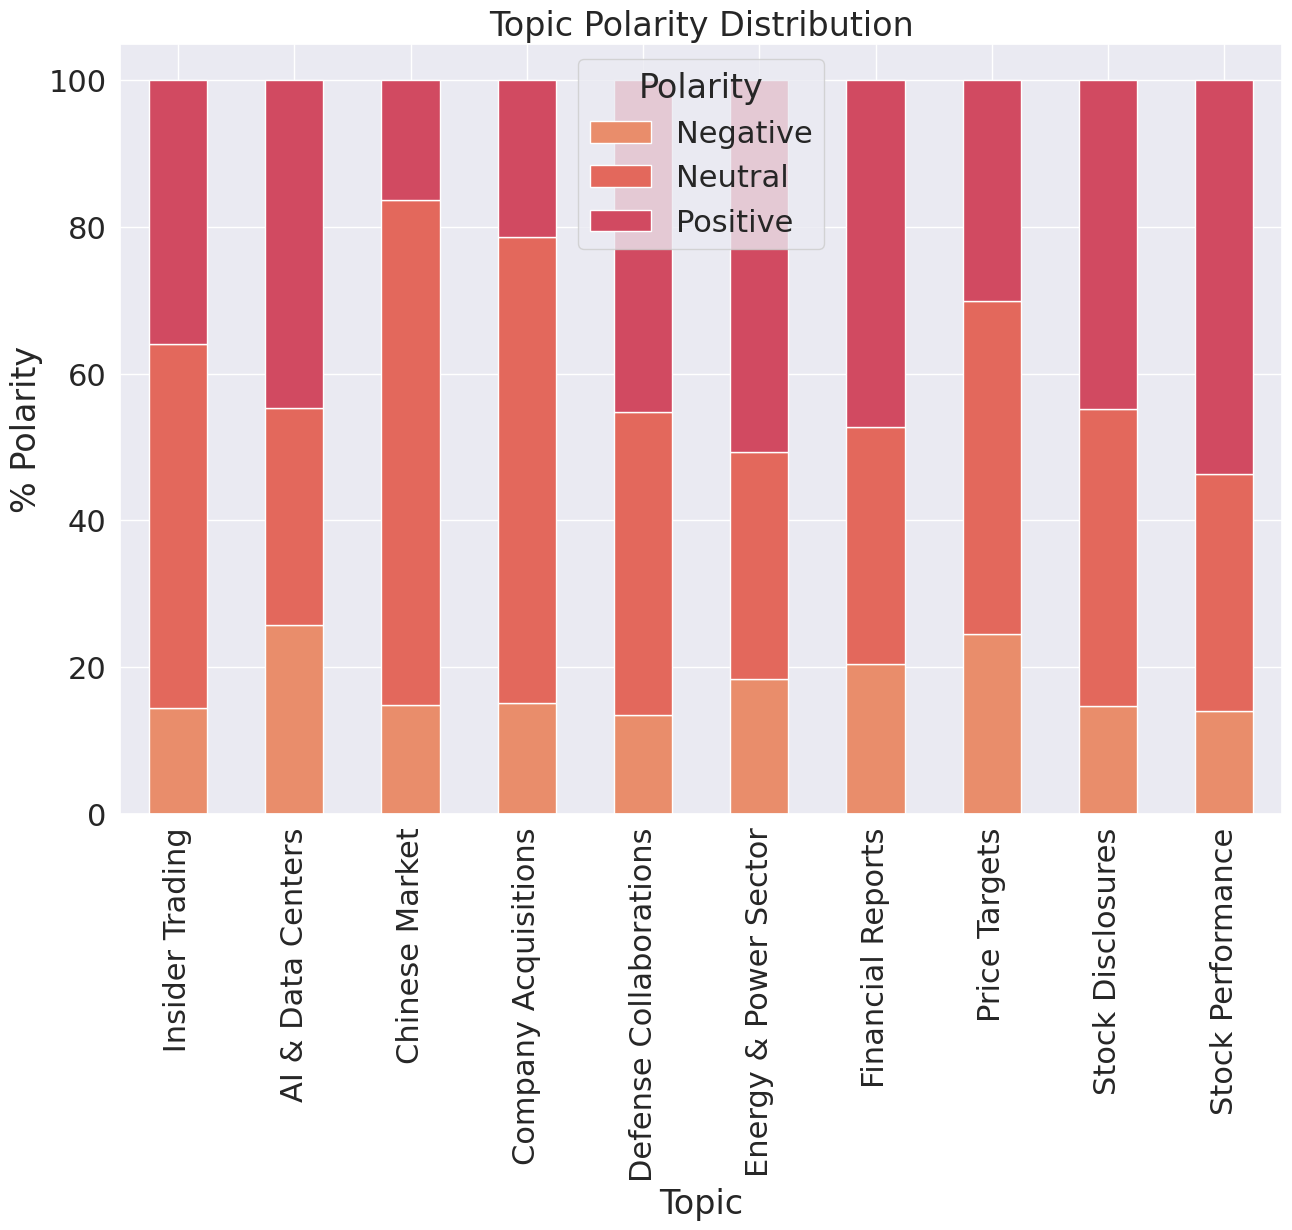

In [64]:
# Create a new dataframe with topic names and polarity percentages
df_topic_polarity = df_1.groupby('Topic')['Analysis_Polarity'].value_counts().unstack(fill_value=0).apply(lambda x: x / x.sum() * 100, axis=1)

# Create the stacked bar plot
ax = df_topic_polarity.plot(kind='bar',color=sns.palettes.mpl_palette('flare'), stacked=True, figsize=(15, 10))

# Add labels and title
ax.set_xlabel('Topic')
ax.set_ylabel('% Polarity')
ax.set_title('Topic Polarity Distribution')

# Add topic names to the x-axis
ax.set_xticklabels(df_topic_polarity.index, rotation=90)

# Add legend
ax.legend(title='Polarity')

# Show the plot
plt.show()


###Perform Topic Labeling to analyze the polarity score of each of the topics identified.

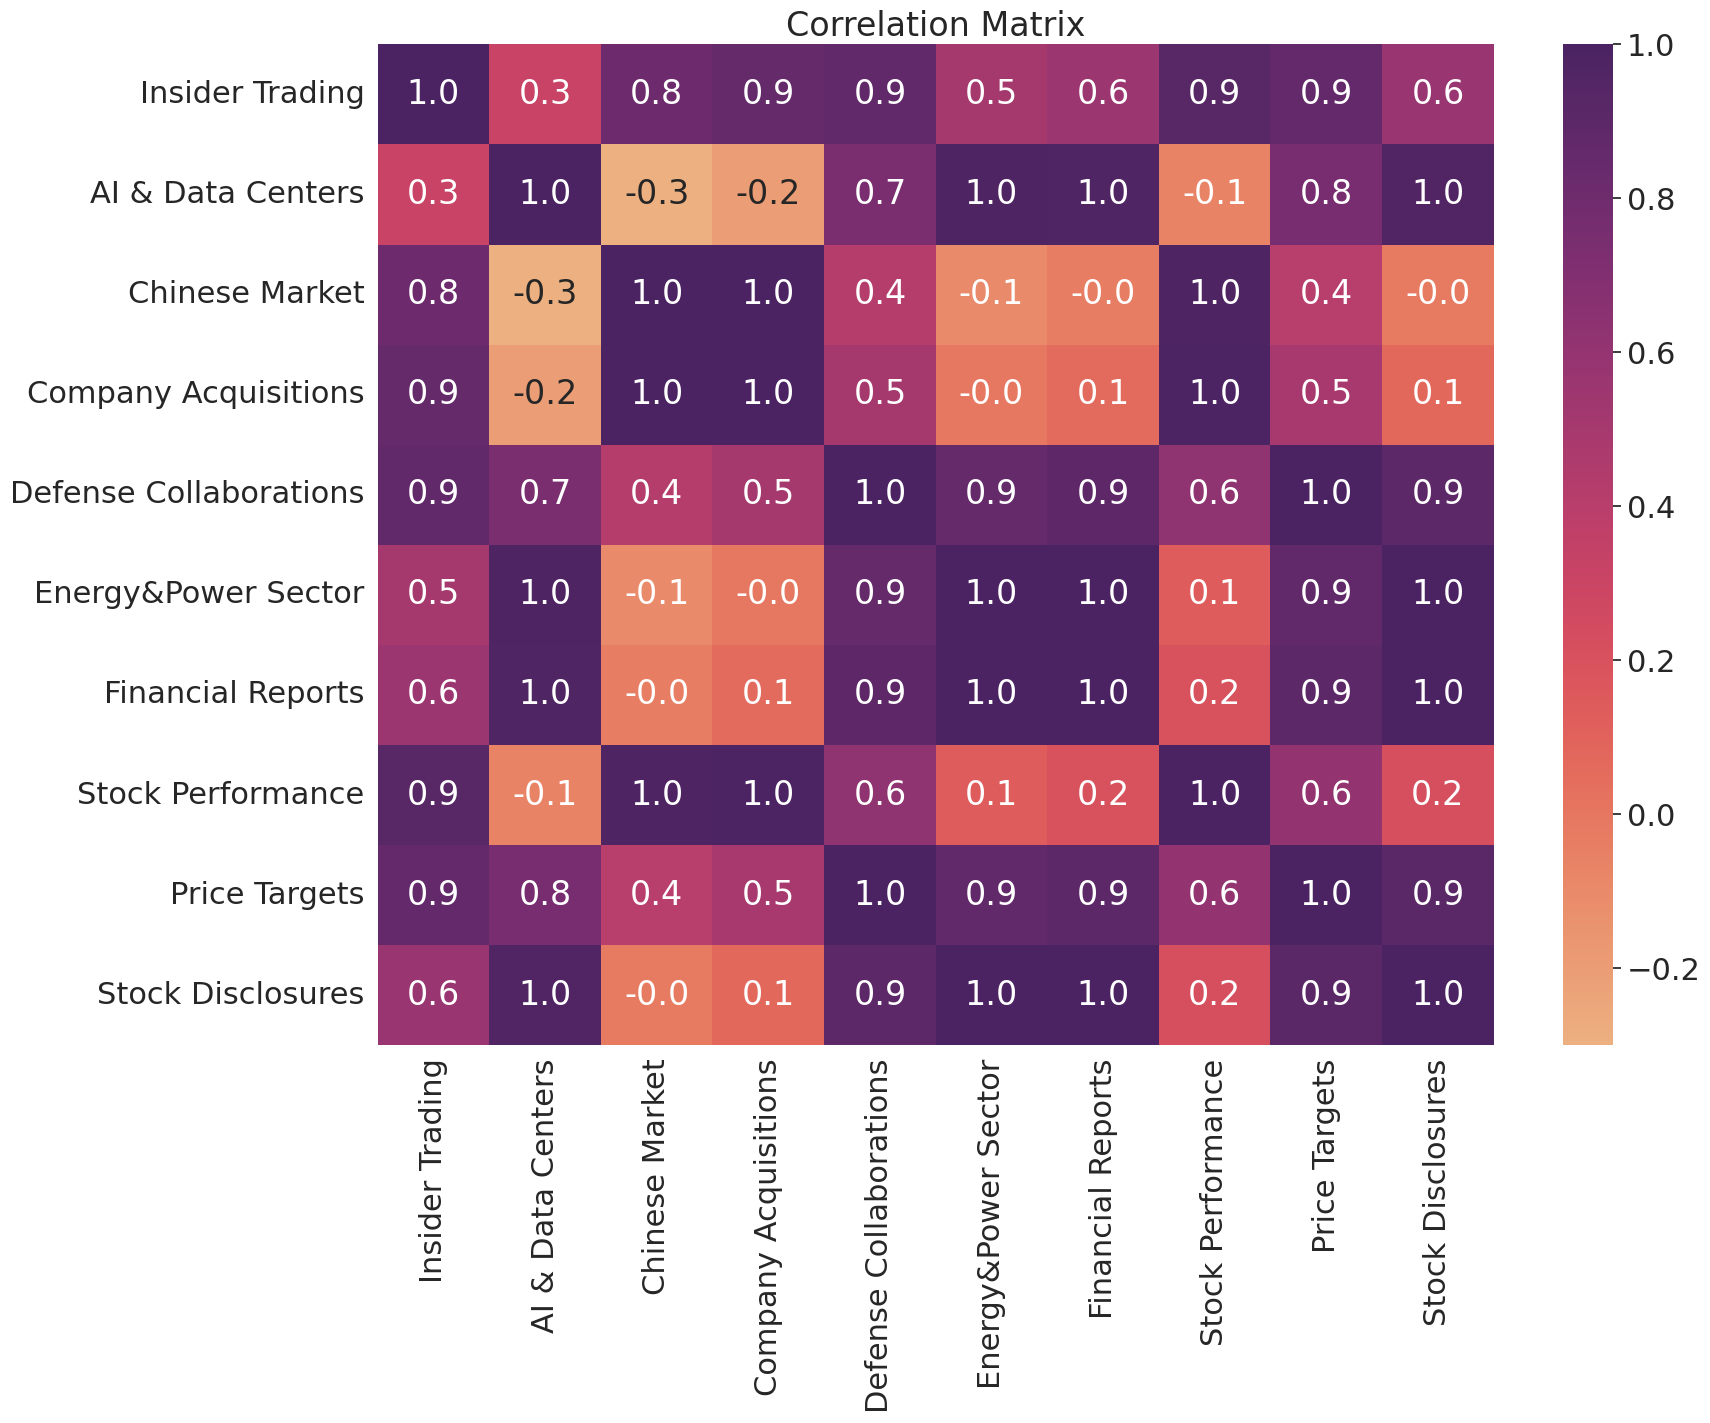

In [65]:
# Define the data
topic_names = [
    "Insider Trading",
    "AI & Data Centers",
    "Chinese Market",
    "Company Acquisitions",
    "Defense Collaborations",
    "Energy&Power Sector",
    "Financial Reports",
    "Stock Performance",
    "Price Targets",
    "Stock Disclosures",]

# Get the topic-polarity matrix
topic_polarity_matrix = df_topic_polarity.values

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(topic_polarity_matrix)
fig, ax = plt.subplots(figsize=(18, 13))
sns.heatmap(correlation_matrix, annot=True, cmap="flare", fmt=".1f", xticklabels=topic_names, yticklabels=topic_names)
plt.title("Correlation Matrix")
plt.show()

###Plot dendongram chart for the topic identified

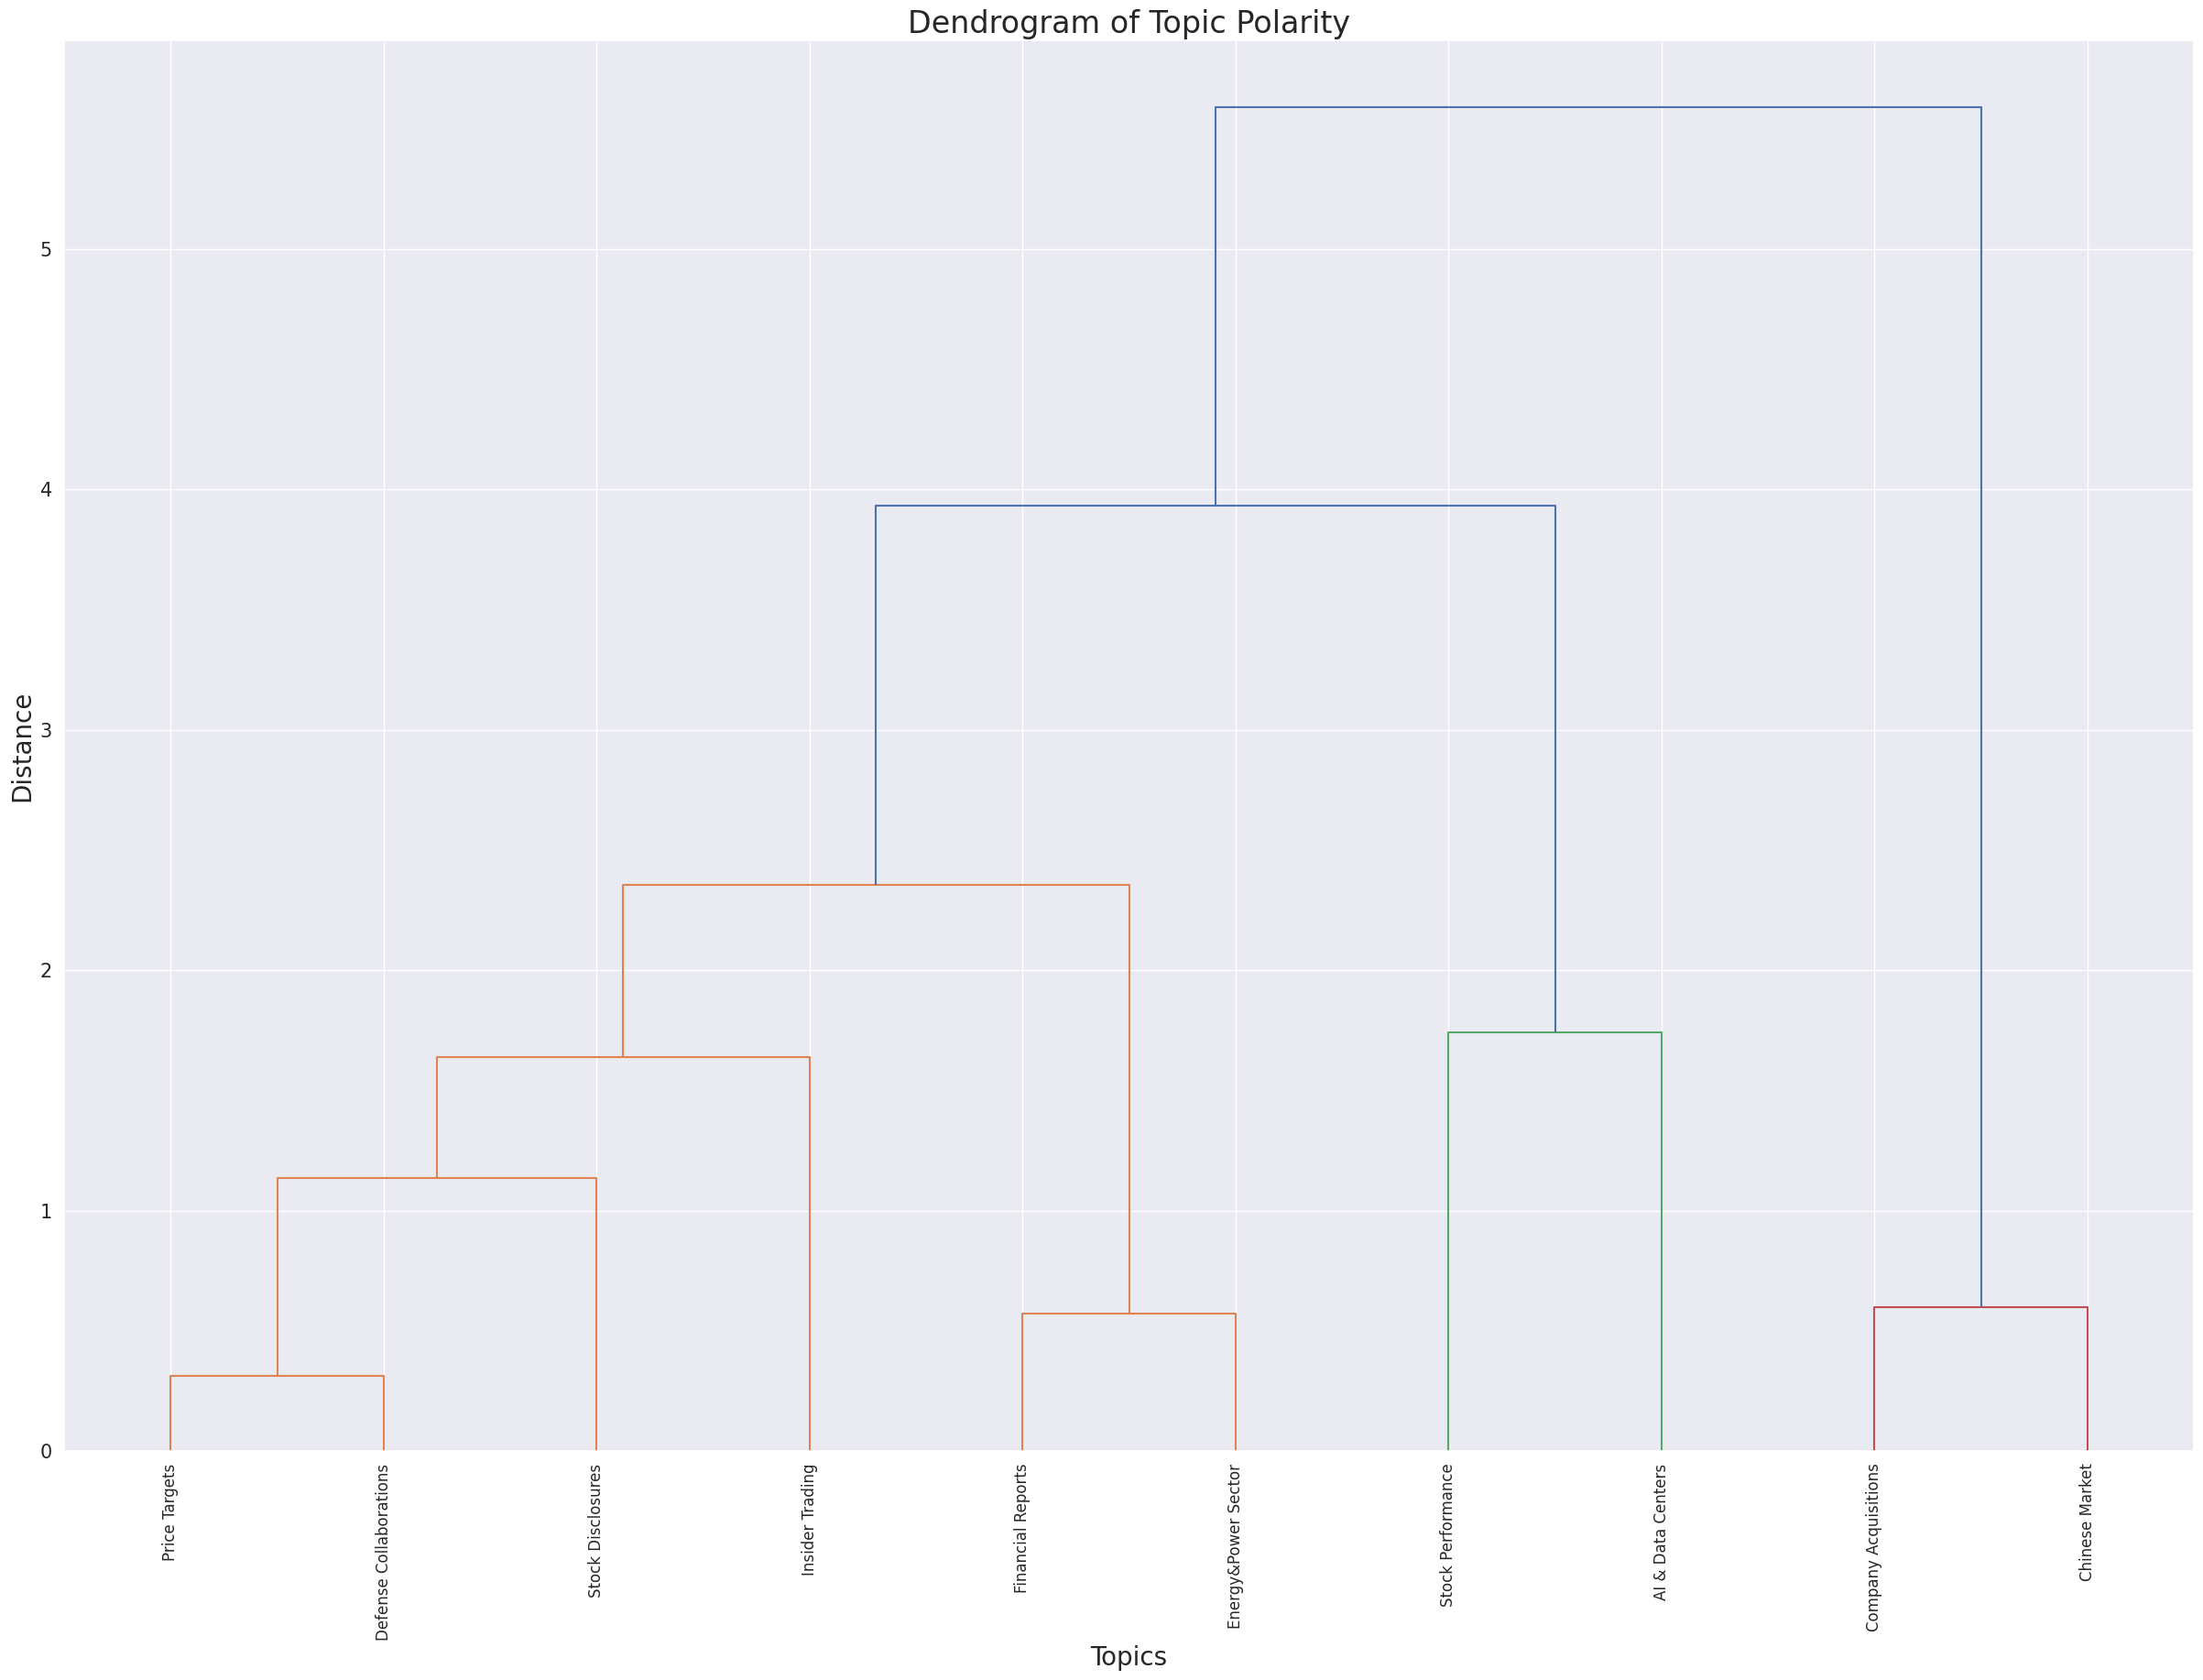

In [66]:

import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import StandardScaler

# Standardize the topic-polarity matrix
scaler = StandardScaler()
scaled_topic_polarity_matrix = scaler.fit_transform(topic_polarity_matrix)

# Calculate the linkage
linkage_matrix = sch.linkage(scaled_topic_polarity_matrix, method='ward')

# Create the dendrogram
plt.figure(figsize=(30, 20))
sch.dendrogram(linkage_matrix, orientation='top', distance_sort='descending', labels=topic_names)
plt.title('Dendrogram of Topic Polarity', size=24)
plt.xlabel('Topics', size=20)
plt.ylabel('Distance', size=20)
plt.tick_params(axis='x', rotation=90)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.show()


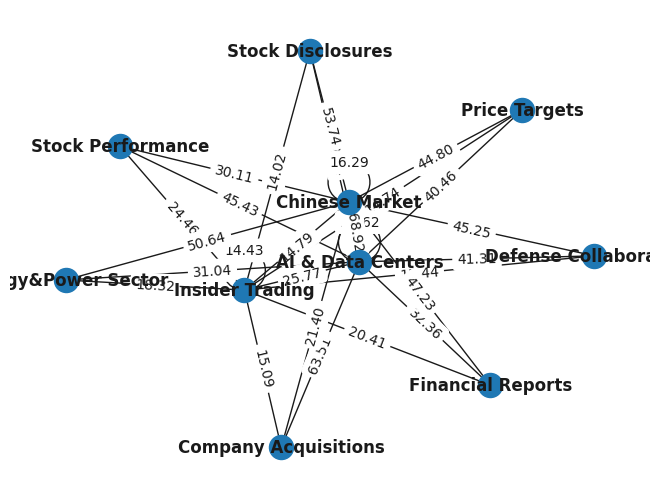

In [67]:
# Create a graph
G = nx.Graph()

# Add nodes to the graph
G.add_nodes_from(topic_names)

# Add edges to the graph based on the polarity matrix
for i in range(len(topic_polarity_matrix)):
    for j in range(len(topic_polarity_matrix[0])):
        if topic_polarity_matrix[i][j] > 0.5:
            G.add_edge(topic_names[i], topic_names[j], weight=topic_polarity_matrix[i][j])

# Set the layout of the nodes
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, font_weight='bold')

# Set the edge labels
edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Show the plot
plt.show()


###Load libraries for Network Analysis

###Check for the degree of centrality and betweenness for the topics identified

In [68]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)

# Print the results
print("Degree Centrality:")
for node, centrality in degree_centrality.items():
    print(f"{node}: {centrality}")

print("\nBetweenness Centrality:")
for node, centrality in betweenness_centrality.items():
    print(f"{node}: {centrality}")


Degree Centrality:
Insider Trading: 1.222222222222222
AI & Data Centers: 1.222222222222222
Chinese Market: 1.222222222222222
Company Acquisitions: 0.3333333333333333
Defense Collaborations: 0.3333333333333333
Energy&Power Sector: 0.3333333333333333
Financial Reports: 0.3333333333333333
Stock Performance: 0.3333333333333333
Price Targets: 0.3333333333333333
Stock Disclosures: 0.3333333333333333

Betweenness Centrality:
Insider Trading: 0.19444444444444442
AI & Data Centers: 0.19444444444444442
Chinese Market: 0.19444444444444442
Company Acquisitions: 0.0
Defense Collaborations: 0.0
Energy&Power Sector: 0.0
Financial Reports: 0.0
Stock Performance: 0.0
Price Targets: 0.0
Stock Disclosures: 0.0


In [69]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

# Assuming 'Analysis_Polarity' is your target variable and other relevant features are in X
X = df[['Polarity', 'Subjectivity', 'Topic']]  # Example features, replace with your actual features
y = df['Analysis_Polarity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', multi_class='auto')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVC', SVC(gamma='scale')))
models.append(('RFC', RandomForestClassifier(n_estimators=100)))
models.append(('DTC', DecisionTreeClassifier()))
models.append(('GBC', GradientBoostingClassifier()))


# Evaluate models
results = []
names = []
for name, model in models:
    try:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Model: {name}, Accuracy: {accuracy}")
        print(classification_report(y_test, y_pred))
        results.append(accuracy)
        names.append(name)
    except Exception as e:  # Handle potential errors during model training/prediction
        print(f"Error with model {name}: {e}")
        results.append(0)
        names.append(name)


Model: LR, Accuracy: 0.9202988792029888
              precision    recall  f1-score   support

    Negative       1.00      0.78      0.88       144
     Neutral       0.89      0.95      0.92       376
    Positive       0.93      0.95      0.94       283

    accuracy                           0.92       803
   macro avg       0.94      0.89      0.91       803
weighted avg       0.92      0.92      0.92       803

Model: KNN, Accuracy: 0.9676214196762142
              precision    recall  f1-score   support

    Negative       0.94      0.92      0.93       144
     Neutral       0.97      0.97      0.97       376
    Positive       0.98      0.98      0.98       283

    accuracy                           0.97       803
   macro avg       0.96      0.96      0.96       803
weighted avg       0.97      0.97      0.97       803

Model: NB, Accuracy: 0.9763387297633873
              precision    recall  f1-score   support

    Negative       1.00      0.92      0.96       144
     Neu

In [70]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

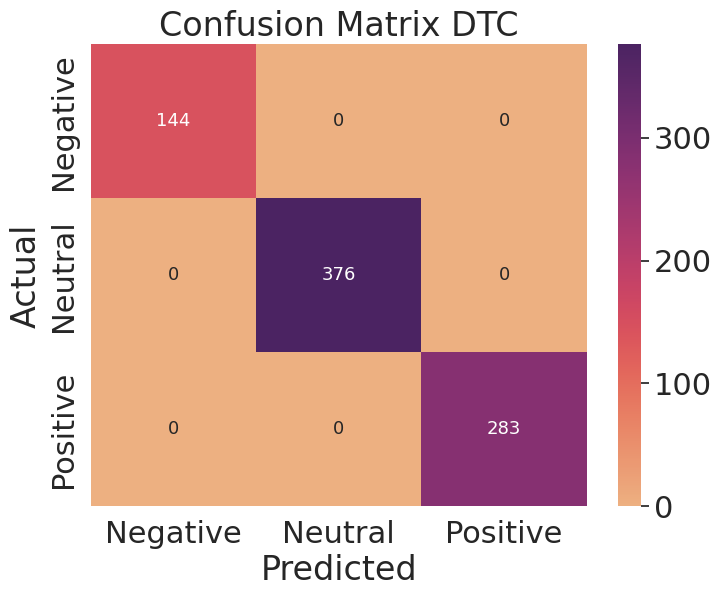

In [71]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="flare",
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'],
            annot_kws={"size": 13})
plt.title("Confusion Matrix DTC")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')